# Classify A Doctor's Consultation Fee

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score,classification_report,confusion_matrix

%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
#read csv to df
df = pd.read_csv('.\dataset\clean_Final_Train.csv')

# Feature engineering

In [3]:
df.city.unique()
#top tier cities will have a value of 0
top=['Bangalore', 'Chennai', 'Delhi', 'Hyderabad' ,'Mumbai']
df['top_tier']=df.city.apply(lambda x : 0 if x in top else 1 )

# Modelling

In [4]:
df.Fees.describe().round()

count    5937.0
mean      309.0
std       191.0
min         5.0
25%       150.0
50%       300.0
75%       500.0
max       950.0
Name: Fees, dtype: float64

In [5]:
#Median is 300.
#Anything below 300 is cheap
df['cheap']=df.Fees.apply(lambda x : 1 if x <= 300 else 0)

In [6]:
#there's no extreme imbalance class
df.cheap.value_counts(normalize=True).round(2)

1    0.63
0    0.37
Name: cheap, dtype: float64

In [7]:
print(f'Baseline prediction  = {round(df.cheap.sum()/len(df),2)}')

Baseline prediction  = 0.63


In [8]:
drop_cols=['Fees','cheap']

#assign predictor and target variables
X=df.drop(drop_cols,axis=1)
y=df.cheap

In [9]:
# Create dummy variables( One Hot Encoding) for all categorical columns.

def ohe(df):
    '''
    get_dummies are created by just providing the DataFrame
    continuous variables will not be ohe-ed
    
    remember to include your dependent variable too
    function will returned an EXPLODED dataframe
    '''    
    #cycle through all the columns at the df
    for col in df.columns:
        #if col if it's an object, get_dummy on it and concat to a df
        if col in df.select_dtypes('object').columns.values: 
            dummy = pd.get_dummies(df[col], drop_first=True, prefix=col,dtype=int)
            df = pd.concat([df, dummy], axis=1)
            #drop the col after it has been encoded
            df.drop(col, axis=1, inplace=True)
    return df

X=ohe(X)

In [10]:
#Train-test split based on Pareto rule, 90% train and 10% test
X_train, X_test, y_train, y_test = train_test_split\
                (X, y, test_size=0.1, random_state=42,stratify=y)

In [11]:
#Standard Scale the X-train and X_test(only transform)
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test =ss.transform(X_test)

## Modelling

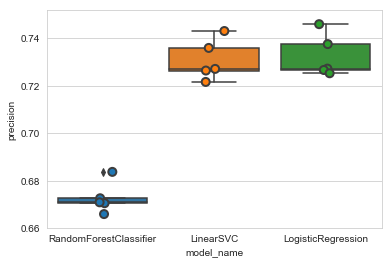

In [12]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='precision', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'precision'])
import seaborn as sns
sns.boxplot(x='model_name', y='precision', data=cv_df)
sns.stripplot(x='model_name', y='precision', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [13]:
#for now it's only 5% better than RF
cv_df.groupby('model_name').precision.mean().round(2)

model_name
LinearSVC                 0.73
LogisticRegression        0.73
RandomForestClassifier    0.67
Name: precision, dtype: float64

In [14]:
logreg=LogisticRegression(solver='liblinear',penalty='l1',n_jobs=-1,random_state=42)

In [15]:
scores = cross_val_score(logreg,X_train, y_train, cv=5, scoring='accuracy')
print('Cross-Validation Accuracy : mean {} ,  std dev : {}\n'.format(round(np.mean(scores),2), round(np.std(scores),2)))

Cross-Validation Accuracy : mean 0.7 ,  std dev : 0.01



In [16]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [17]:
print('Logistic Regression , Precision %s\n' % f1_score(y_pred, y_test).round(2))
print(classification_report(y_test, y_pred,target_names=['expensive','cheap']))

Logistic Regression , Precision 0.79

              precision    recall  f1-score   support

   expensive       0.64      0.49      0.55       219
       cheap       0.74      0.84      0.79       375

   micro avg       0.71      0.71      0.71       594
   macro avg       0.69      0.66      0.67       594
weighted avg       0.70      0.71      0.70       594



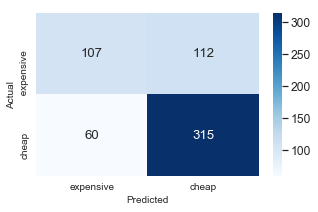

In [18]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,3))
sns.set(font_scale=1.1)
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=['expensive','cheap'],\
           yticklabels=['         expensive','cheap'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
coef=pd.DataFrame(np.transpose(logreg.coef_),index=X.columns,columns=['co-ef'])
coef=coef.sort_values(by='co-ef',ascending=False)
coef['odds']=round(np.exp(coef['co-ef']),2)

In [20]:
coef

,co-ef,odds
Profile_Dentist,0.610888,1.84
top_tier,0.499443,1.65
city_Coimbatore,0.361021,1.43
city_Chennai,0.203287,1.23
city_Hyderabad,0.147326,1.16
bams,0.130323,1.14
mbbs,0.088777,1.09
Experience,0.077588,1.08
ent,0.041602,1.04
post,0.017867,1.02
